<a href="https://www.kaggle.com/code/lonnieqin/logistic-regression-model-from-scratch?scriptVersionId=148100434" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Logistic Regression Model from Scratch
In this notebook, I will create a Logistic Regression model trained on [Binary Classification with a Software Defects Dataset
](https://www.kaggle.com/competitions/playground-series-s3e23) from scratch. I will also train this dataset with SKLearn version [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for comparation. Finally I will create an ensemble submission with these two kinds of models. In the future, I wll explore accelerating this model using [jax](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html).

## Import packages

In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from sklearn.model_selection import StratifiedKFold
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

## Load data

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e23/train.csv")
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [3]:
feature_columns = list(train.columns)
feature_columns.remove("id")
target_column = "defects"
feature_columns.remove(target_column)

In [4]:
train[target_column] = train[target_column].astype(np.int)

/tmp/ipykernel_20/4050492016.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train[target_column] = train[target_column].astype(np.int)


## Feature scaling

In [5]:
scaler = StandardScaler()
train[feature_columns] = scaler.fit_transform(train[feature_columns])

## Modeling

In [6]:
from tqdm.notebook import tqdm
class LogisticRegression:
    
    epsilon = 1e-10
    
    def __init__(
        self, 
        lambda_=1, 
        alpha = 1e-3, 
        batch_size=32,
        num_iters=30
    ):
        self.lambda_ = lambda_
        self.alpha = alpha
        self.num_iters = num_iters
        self.batch_size = batch_size

    def sigmoid(self, z):
        return  1.0 / (1.0 + jnp.exp(-z))
    
    def compute_cost(self, X, y):
        z_wb = jnp.dot(X, self.w) + self.b
        f_wb = self.sigmoid(z_wb)
        total_cost = -1.0 * (y * jnp.log(f_wb + self.epsilon) + (1.0 - y + self.epsilon) * jnp.log(1.0 - f_wb + self.epsilon))
        return np.mean(total_cost)
    
    def compute_gradient(self, X, y): 
        m, n = X.shape
        z_wb = jnp.dot(X, self.w) + self.b
        f_wb = self.sigmoid(z_wb)
        err = f_wb - y
        dj_dw = jnp.mean(np.dot(X.T, err), axis=-1, keepdims=True)
        dj_db = jnp.mean(err)
        return dj_db, dj_dw

    def fit(self, X, y, eval_set): 
        num_features = X.shape[-1]
        self.w = np.random.rand(num_features).reshape(-1,1)
        self.b = np.random.rand()
        self.losses = []
        self.accuracies = []
        self.aucs = []
        best_loss = 100.0
        best_accuracy = 0.0
        self.best_auc = 0.0
        self.best_iter = 0
        for i in tqdm(range(self.num_iters)):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            num_batch = len(indices) // self.batch_size + (0 if len(indices) % self.batch_size == 0 else 1)
            for j in range(num_batch):
                lower_bound = j * self.batch_size
                upper_bound = min((j + 1) * self.batch_size, len(X) - 1)
                current_indices = indices[lower_bound : upper_bound]
                X_batch = X[current_indices]
                y_batch = y[current_indices]
                dj_db, dj_dw = self.compute_gradient(X_batch, y_batch)
                self.w = self.w - self.alpha * dj_dw   
                self.b = self.b - self.alpha * dj_db  
            loss = self.compute_cost(eval_set[0], eval_set[1])
            logits = self.predict_proba(eval_set[0])
            acc = (jnp.array(logits >= 0.5, dtype=int) == eval_set[1]).mean()
            auc_score = roc_auc_score(eval_set[1], logits)
            if auc_score >= self.best_auc:
                self.best_weight = self.w.copy()
                self.best_bias = self.b.copy()
                self.best_iter = i
                self.best_auc = auc_score
            
            self.losses.append(loss)
            self.accuracies.append(acc)
            self.aucs.append(auc_score)
            print(f"Loss:{loss:.4f} accuracy: {acc:.4f} auc:{auc_score:.4f}")
            if i - self.best_iter >= 10:
                print("model stop improving, stop training.")
                break
            gc.collect()
        self.w = self.best_weight
        self.b = self.best_bias
        
        
    def predict_proba(self, X): 
        z_wb = jnp.dot(X, self.w) + self.b
        return self.sigmoid(z_wb)
            
    def predict(self, X): 
        f_wb = self.predict_proba(X)
        return jnp.array(f_wb >= 0.5, dtype=int)

## Model training

In [7]:
models =[]
cross_validations = [StratifiedKFold(5, shuffle=True, random_state=np.random.randint(2048)) for i in range(1)]
oofs = []
for kfold in cross_validations:
    for train_indices, valid_indices in kfold.split(train, train[target_column]):
        model = LogisticRegression()
        model.fit(
            train.iloc[train_indices][feature_columns].to_numpy(), 
            train.iloc[train_indices][target_column].to_numpy(), 
            eval_set=(
                train.iloc[valid_indices][feature_columns].to_numpy(), 
                train.iloc[valid_indices][target_column].to_numpy()
            )
        )
        models.append(model)
        oofs.append(model.best_auc)
print(f"OOF:{np.mean(oofs)}")

  0%|          | 0/30 [00:00<?, ?it/s]

Loss:0.6300 accuracy: 0.7712 auc:0.6314
Loss:0.5667 accuracy: 0.7726 auc:0.7309
Loss:0.5464 accuracy: 0.7733 auc:0.7653
Loss:0.5394 accuracy: 0.7734 auc:0.7511
Loss:0.5369 accuracy: 0.7734 auc:0.7520
Loss:0.5359 accuracy: 0.7734 auc:0.7638
Loss:0.5355 accuracy: 0.7734 auc:0.7615
Loss:0.5354 accuracy: 0.7734 auc:0.7679
Loss:0.5354 accuracy: 0.7734 auc:0.7642
Loss:0.5353 accuracy: 0.7734 auc:0.7673
Loss:0.5352 accuracy: 0.7734 auc:0.6809
Loss:0.5352 accuracy: 0.7734 auc:0.7595
Loss:0.5364 accuracy: 0.7731 auc:0.7600
Loss:0.5353 accuracy: 0.7734 auc:0.7350
Loss:0.5354 accuracy: 0.7734 auc:0.7541
Loss:0.5353 accuracy: 0.7734 auc:0.7671
Loss:0.5353 accuracy: 0.7734 auc:0.7605
Loss:0.5353 accuracy: 0.7734 auc:0.7590
model stop improving, stop training.


  0%|          | 0/30 [00:00<?, ?it/s]

Loss:0.5994 accuracy: 0.7715 auc:0.6710
Loss:0.5569 accuracy: 0.7733 auc:0.6361
Loss:0.5432 accuracy: 0.7732 auc:0.7167
Loss:0.5382 accuracy: 0.7734 auc:0.6532
Loss:0.5364 accuracy: 0.7734 auc:0.7350
Loss:0.5358 accuracy: 0.7734 auc:0.7435
Loss:0.5356 accuracy: 0.7733 auc:0.7581
Loss:0.5354 accuracy: 0.7734 auc:0.7546
Loss:0.5353 accuracy: 0.7734 auc:0.7700
Loss:0.5353 accuracy: 0.7734 auc:0.5917
Loss:0.5355 accuracy: 0.7733 auc:0.7552
Loss:0.5353 accuracy: 0.7734 auc:0.7704
Loss:0.5353 accuracy: 0.7734 auc:0.7652
Loss:0.5355 accuracy: 0.7733 auc:0.7346
Loss:0.5353 accuracy: 0.7734 auc:0.7304
Loss:0.5354 accuracy: 0.7734 auc:0.7558
Loss:0.5353 accuracy: 0.7734 auc:0.7394
Loss:0.5357 accuracy: 0.7732 auc:0.7662
Loss:0.5356 accuracy: 0.7732 auc:0.7674
Loss:0.5353 accuracy: 0.7734 auc:0.7511
Loss:0.5353 accuracy: 0.7734 auc:0.7653
Loss:0.5353 accuracy: 0.7734 auc:0.7240
model stop improving, stop training.


  0%|          | 0/30 [00:00<?, ?it/s]

Loss:0.6217 accuracy: 0.7699 auc:0.6148
Loss:0.5639 accuracy: 0.7729 auc:0.6059
Loss:0.5455 accuracy: 0.7733 auc:0.6073
Loss:0.5392 accuracy: 0.7733 auc:0.7143
Loss:0.5368 accuracy: 0.7733 auc:0.7367
Loss:0.5358 accuracy: 0.7733 auc:0.7370
Loss:0.5356 accuracy: 0.7733 auc:0.7750
Loss:0.5354 accuracy: 0.7734 auc:0.7695
Loss:0.5353 accuracy: 0.7734 auc:0.7486
Loss:0.5353 accuracy: 0.7734 auc:0.7682
Loss:0.5352 accuracy: 0.7734 auc:0.7319
Loss:0.5354 accuracy: 0.7733 auc:0.7721
Loss:0.5353 accuracy: 0.7734 auc:0.7588
Loss:0.5354 accuracy: 0.7734 auc:0.7683
Loss:0.5353 accuracy: 0.7734 auc:0.7373
Loss:0.5353 accuracy: 0.7734 auc:0.7560
Loss:0.5353 accuracy: 0.7734 auc:0.7592
model stop improving, stop training.


  0%|          | 0/30 [00:00<?, ?it/s]

Loss:0.5894 accuracy: 0.7724 auc:0.6164
Loss:0.5540 accuracy: 0.7732 auc:0.6362
Loss:0.5422 accuracy: 0.7733 auc:0.7346
Loss:0.5379 accuracy: 0.7733 auc:0.7343
Loss:0.5365 accuracy: 0.7733 auc:0.7355
Loss:0.5358 accuracy: 0.7733 auc:0.7565
Loss:0.5354 accuracy: 0.7734 auc:0.5200
Loss:0.5353 accuracy: 0.7734 auc:0.7064
Loss:0.5353 accuracy: 0.7734 auc:0.7535
Loss:0.5353 accuracy: 0.7734 auc:0.7482
Loss:0.5354 accuracy: 0.7734 auc:0.7550
Loss:0.5352 accuracy: 0.7734 auc:0.7528
Loss:0.5353 accuracy: 0.7734 auc:0.7615
Loss:0.5354 accuracy: 0.7733 auc:0.7528
Loss:0.5355 accuracy: 0.7733 auc:0.7542
Loss:0.5352 accuracy: 0.7734 auc:0.7498
Loss:0.5353 accuracy: 0.7734 auc:0.7273
Loss:0.5353 accuracy: 0.7734 auc:0.7692
Loss:0.5353 accuracy: 0.7734 auc:0.7661
Loss:0.5353 accuracy: 0.7734 auc:0.7704
Loss:0.5352 accuracy: 0.7734 auc:0.7590
Loss:0.5352 accuracy: 0.7734 auc:0.7176
Loss:0.5353 accuracy: 0.7734 auc:0.7473
Loss:0.5354 accuracy: 0.7734 auc:0.7593
Loss:0.5353 accuracy: 0.7734 auc:0.7574


  0%|          | 0/30 [00:00<?, ?it/s]

Loss:0.6371 accuracy: 0.7692 auc:0.6225
Loss:0.5685 accuracy: 0.7731 auc:0.3732
Loss:0.5472 accuracy: 0.7733 auc:0.4668
Loss:0.5398 accuracy: 0.7732 auc:0.7376
Loss:0.5370 accuracy: 0.7733 auc:0.7410
Loss:0.5359 accuracy: 0.7733 auc:0.7377
Loss:0.5357 accuracy: 0.7733 auc:0.7682
Loss:0.5354 accuracy: 0.7733 auc:0.7151
Loss:0.5353 accuracy: 0.7733 auc:0.7494
Loss:0.5354 accuracy: 0.7733 auc:0.7778
Loss:0.5353 accuracy: 0.7733 auc:0.7591
Loss:0.5354 accuracy: 0.7733 auc:0.7710
Loss:0.5353 accuracy: 0.7733 auc:0.7643
Loss:0.5353 accuracy: 0.7733 auc:0.6372
Loss:0.5354 accuracy: 0.7733 auc:0.7752
Loss:0.5353 accuracy: 0.7733 auc:0.7583
Loss:0.5354 accuracy: 0.7733 auc:0.7758
Loss:0.5353 accuracy: 0.7733 auc:0.7089
Loss:0.5354 accuracy: 0.7733 auc:0.7602
Loss:0.5354 accuracy: 0.7733 auc:0.7663
model stop improving, stop training.
OOF:0.7723107040924206


## Train with LogisticRegressionCV

In [8]:
from sklearn.linear_model import LogisticRegressionCV
lr_model = LogisticRegressionCV(
    cv=StratifiedKFold(5, shuffle=True, random_state=np.random.randint(2048)), 
    scoring="roc_auc"
)
lr_model.fit(train[feature_columns], train[target_column])
lr_model.score(train[feature_columns], train[target_column])

0.7801747548452248

## Create submission

In [9]:
test = pd.read_csv("/kaggle/input/playground-series-s3e23/test.csv")
test[feature_columns] = scaler.transform(test[feature_columns])
X_test = test[feature_columns].to_numpy()
test["defects"] = 0.5 * np.mean([
    model.predict_proba(X_test) for model in models
], axis=0).reshape(-1) + 0.5 * lr_model.predict_proba(test[feature_columns])[:, 1].reshape(-1)
test[["id", "defects"]].to_csv("submission.csv", index=False)
test[["id", "defects"]].head()

,id,defects
0,101763,0.237907
1,101764,0.224963
2,101765,0.412751
3,101766,0.301578
4,101767,0.197014


<Axes: ylabel='Density'>

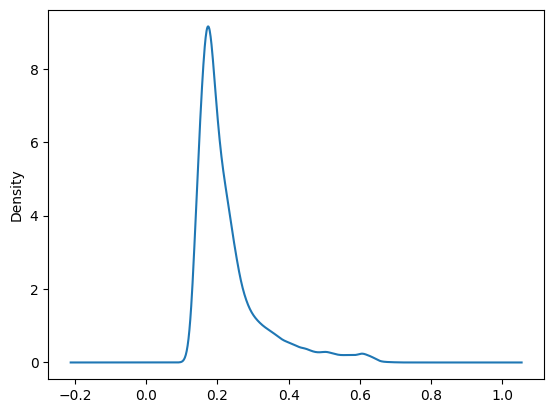

In [10]:
test["defects"].plot(kind="kde")